In [1]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List

dataset = pd.read_csv('data/synchronized-eeg.csv',
                      parse_dates=['indra_time'],
                      index_col ='indra_time')
# convert to arrays from strings
dataset.raw_values = dataset.raw_values.map(json.loads)



Populating the interactive namespace from numpy and matplotlib


# 1. EEG

Neurons produce electrical activity in the brain.

If we zoom out far enough (and, for our purposes, we must), these neuronal firings appear most clearly as patterns of constructive or destructive interference. They are typically low-frequency waves, 0.5Hz-70Hz.

But, don't take my word for it. Let's open up a signal from our corpus.

Here's 512 readings, or one second, of the 30,000 seconds in our dataset. Let's take the 100th reading in our dataset:

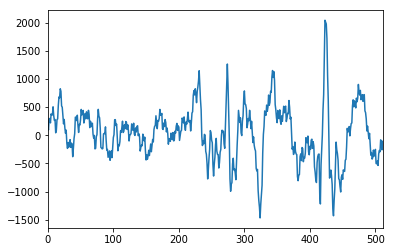

In [2]:
pd.Series(dataset.raw_values[100].values).plot()
plt.show()

This is *time-domain* data. It represents voltages over time.

We can turn this into *frequency-domain* data using an [FFT](https://www.youtube.com/watch?v=iWZNTM139xQ). We'll produce what's called a *power spectrum*.


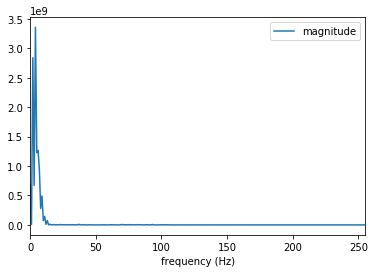

In [3]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.raw_values[1000])
ps.plot(x='frequency (Hz)')
plt.show()

Now, we can see some low-frequency data, toward the left side of the graph

Let's do a "band-pass" between 0.5Hz and 20Hz, effectively "zooming in" or "cropping" to these frequencies.

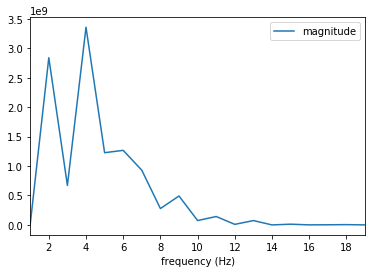

In [88]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')
plt.show()

Now, here's the problem: There's a bunch of other crap in the signal, too!

For example, along with the EEG signal we just saw, there's also a bunch of EMG (electromyographic) data, which is produced by the muscles in your face, or from moving your eyes!

Most of this signal will be in the *50Hz to 150Hz* range. Eyeblinks will cause big spikes in this frequency band.

So we can bandpass to the EMG frequency bands, and plot them. Let's see if we can find any readings with big spikes in this band!

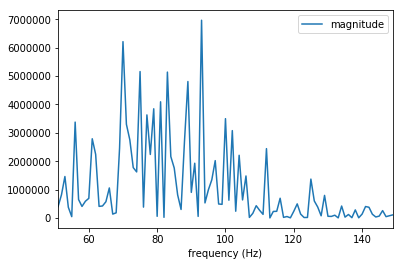

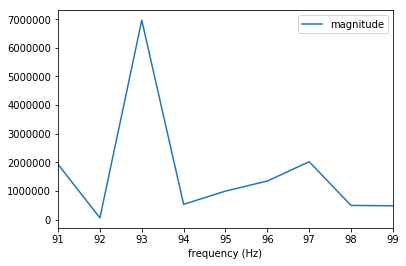

In [89]:
# your code here
bandpass(ps, 50, 150).plot(x='frequency (Hz)')
plt.show()
bandpass(ps, 90, 100).plot(x='frequency (Hz)')
plt.show()


We might also see ECG (electrocardiographic) signals, from the heart.

We'll even see background radiation from the electrical system! Here in North America, we'll see a 60Hz spike no matter what we do.

# 2. Classification

We can go crazy trying to filter all of these artifacts (and many have). 

However, we are at Berkeley, so we will take a lazy (computational) view.

We will shift our perspective in two ways, and in the end, we will not feel obligated to filter artifacts:

1. *The electromagnet is a general-purpose **biosensor***. We are sensing a multitude of human activity, including, but not limited to, EEG.

2. *Our machine learning will handle the artifacts*. If some artifacts really are artifacts (i.e., they are not informative with respect to our problem domain), then our ML will simply learn to ignore them.

`<OPTIONAL NOTE>`

These two "perspective shifts" are tightly intertwined. If you are up for it, try using the second as a lens for viewing the first. Our assumptions about EEG melt away, and we are left only with a classification problem and a signal (and the assumptions [built into those infrastructures](https://mitpress.mit.edu/books/raw-data-oxymoron) ;) ). 

We do not need to make specific commitments about what mechanisms produce the effects we are interested in. Thus, we avoid all hard epistemolgical questions (and complaints)! We are also free to discover signals that might come from unexpected places.  

Just remember this: If we're trying to classify interest (say), perhaps an unconscious eyebrow raise is our key signal. It would be a shame if we filtered it out, in our myopic quest for a "clean" EEG signal!

`</OPTIONAL NOTE>`

Fine, so what kind of classifier will just handle the artifacts for us?
I know, I know, you're probably thinking of neural networks. [That's an option](https://arxiv.org/pdf/1611.08024.pdf).

But, for now, we will use something much simpler, and much easier to run on your laptop: [XGBoost](https://github.com/dmlc/xgboost). [Read up](https://xgboost.readthedocs.io/en/latest/model.html) on XGBoost.

First, let's make a plain, *untrained* classifier.

In [90]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

clf = fresh_clf()


Right now, this classifier is fresh to the world. It has seen no evil, heard no evil...

The "learning" part happens when our  classifier is *trained*, or *fit*, using examples. These examples have *labels*, and *features*. Our classifier will study the relationship between features and labels, so that in the future, it can map features to labels (more on this in a second).

Our **features** here are pretty clear: electromagnetic signals, our power spectra.

Our **labels** can really be anything, but for now, let's pick stuff that's easy from the existing dataset: People who are doing math, and people who are doing nothing. 

In [91]:
# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax') &
                (dataset.id == 1) ]
# All the readings taken during "math" tasks
# (Math tasks were labeled math1...math12 -
#  `math\d` is a "regular expression," or RegEx)
math = dataset[(dataset.label.str.match('math\d')) &
               (dataset.id == 1) ]

len(relax), len(math)

(30, 30)

Now, we'll go about preparing our data for the classifier. 

Since our features are the power spectra, we should assemble a big collection of power spectra - and nothing else.

In [92]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

Now we can make a big list of all features, with their labels removed.

In [93]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

However, for each of these features, we will need corresponding labels.

Since our machine has no semantic knowledge of what these labels "mean," we will simply refer to them as 0 and 1, respectively.

In [94]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

What we are left with are two matrices (numpy arrays): one of the features, and one of the labels. The labels matrix is one-dimensional. 

The features matrix can be have another dimension of any length. However, along its first dimension, it must be the same shape as the labels, so that the two align (every feature has a label).

So, here, our labels are `n x 1`, and our features are `256 x n`. (Our sampling rate is 512, producing power spectra of size 256.)


In [95]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

By convention, we refer to the features matrix as `X` and the labels matrix as `y`. 

(I know, I know. Mathematicians have no idea how to name a variable. But, the variable names `X` and `y` are so common in literature and documentation, I feel you should be familiar with them. And thus I perpetuate the problem...)

In [96]:
X = features
y = labels

Now, we can finally train our classifier!

In [97]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

Great, we trained it! So, how does it do?

Aha, but if we've used all of our data to trian the classifier, what can we use to *test* the classifier?

We could test the classifier on the exact same stuff we trained it on, but *WE SHOULD NEVER DO THIS!!! NEVER TEST ON THE TRAIN SET!!* 

Why? The answer has to do with a concept called *overfitting*. 

> A model *overfits* to its data when it explains the data it was trained on *so exactly* that it no longer generalizes to new, unseen data. 

For example, a model may memorize the data, including noise in the data, to produce perfect accuracy. Effectively, it will memorize the data! How useful will this memorization be in classifying data it's never seen before? Not very!

To get around this, we *split* the data into train and test sets.

In [98]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

# (Remember, there's nothing "random" on a computer,
#  but, we do have *pseudo-*random number generators
#  (PRNGs) which are almost as good. If we fix the seed,
#  they will always generate the same sequence of numbers.
#  However, to someone who doesn't know the seeds, the
#  numbers look like white noise. Magic! You ever wonder
#  how garage door openers work? Research more
#  on your own time.)

Now we can train a *fresh* classifier on the train set,

In [99]:
clf = fresh_clf()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

and test on the test set!

In [100]:
clf.score(X_test, y_test)

0.90000000000000002

But XGBoost is even smarter than that. 

Oh yes, XGBoost is very smart. It can take some data, randomly split it into train and test sets, then see how well it does on the test set. It will use these results to tweak its parameters. Then, it can repeat this process a number of times, until it starts doing very well!


In [101]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

Now we'll now split the data into a *train* set (for which XGBoost will manage the train/test splitting), and a *validation* set, which we will use to see the results of XGBoost's efforts.

In [102]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

This `cvres` value is actually a DataFrame detailing each "tweaking" step XGBoost did in training the parameters. We can inspect the last few rows to see what it did right before it delievered the classifier to us.

(If you notice in the `xgb_cross_validate` method above, we specified an `early_stopping_rounds`. We keep tweaking parametmers until the results are pretty high, or until we have tried for 100 rounds - whichever comes first).

In [103]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
96,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
97,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
98,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
99,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396


In [104]:
clf.score(X_validate, y_validate)

0.90000000000000002


For how many rounds did XGBoost tweak our classifier, above, before stopping?

100 rounds.

What is the estimated accuracy of our classifier at distinguishing between "math" and "relax" tasks, across all subjects?

62.5%.

In [106]:
relax = dataset[(dataset.label == 'relax')]
math = dataset[(dataset.label.str.match('math\d'))]
len(relax), len(math)
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
assert np.all( [ len(feat) == 256 for feat in features ] )
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])
# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1
labels[:5], labels[-5:]
X = features
y = labels
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)
clf, cvres = xgb_cross_validate(X_train, y_train)
clf.score(X_validate, y_validate)

0.62459546925566345


In this notebook, why did our classifier do as well as it did?

In answering this question, do research, and make educated guesses based on what you learn. Optionally make arguments based on any any evidence you can collect. 

There are no right or wrong answers here. Nor is there only one answer - there are potentially a number of possible explanations! 

Some questions I always ask myself whenever I come up with explanations:

- Could I test this theory? How?
- Are there any *other* explanations? Can I test those?
- Why might the current results be misleading?

1. 
The most obvious explanation, why our classifier did as well as it did, is that we used the classifier on just one participant (dataset.id == 1). This one participant will respond in a very similar manner to the stimuli. However, if used the classifier on all the participants, a much lower accuracy emerges. One reason could be that there were individual differences in how the participants responded. Another reason could be measurement errors for some of the non-(ID == 1)-participants or simply different times when the responses were recorded for each participant (since all the recordings took place at the same time). Another reason for individual differences might be that some subjects did only seemingly participate in the task, but put their attention on other topics.
When looking at the scores below (for how well the classifier did for each participant), we find that for some, it does even better, while for others, it is not better than chance.

In [107]:
# 1. How well does the classifier do for other subjects:
scores = []
for i in range(1,31,1):
    relax = dataset[(dataset.label == 'relax') &
                    (dataset.id == i) ]
    math = dataset[(dataset.label.str.match('math\d')) &
                   (dataset.id == i) ]
    len(relax), len(math)

    relax_features = to_features(relax)
    math_features = to_features(math)
    features = np.concatenate([relax_features, math_features])

    assert np.all( [ len(feat) == 256 for feat in features ] )

    labels = np.array([ 0 for feature in relax_features  ] \
                    + [ 1 for feature in math_features ])


    assert len(labels) == len(features)
    assert labels[0] == 0
    assert labels[-1] == 1

    labels[:5], labels[-5:]

    assert features.shape[0] == labels.shape[0]

    features.shape, labels.shape

    X = features
    y = labels

    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
        X, y, 
        test_size=0.33, 
        random_state=42)

    clf, cvres = xgb_cross_validate(X_train, y_train)
    
    scores.append(clf.score(X_validate, y_validate))

scores


[0.90000000000000002,
 0.76190476190476186,
 0.90000000000000002,
 0.95238095238095233,
 0.5714285714285714,
 0.55000000000000004,
 0.38095238095238093,
 0.69999999999999996,
 0.65000000000000002,
 0.75,
 0.61904761904761907,
 0.59999999999999998,
 0.84999999999999998,
 0.59999999999999998,
 0.55000000000000004,
 0.69999999999999996,
 0.5714285714285714,
 0.69999999999999996,
 0.95454545454545459,
 0.29999999999999999,
 0.65000000000000002,
 0.5,
 0.55000000000000004,
 0.80000000000000004,
 0.5,
 0.47619047619047616,
 0.80000000000000004,
 0.59999999999999998,
 0.80000000000000004,
 0.5714285714285714]

2. 
Continuing with the whole group of participants: Another explanation is that we used cross-validation compared to simply splitting the data set once in a training and a test set. One possibility to test this theory is to change the number of folds and plot the test error depending on the number of folds. Heuristically, I would expect to find that as the number of folds converges towards the sample size, the test error decreases. However, this is not the case.

In [113]:
# 2. Changing the number of folds
num_folds = []
scores = []
for i in [1,2,5,10,100,500,1000]:
    def xgb_cross_validate_nfold (
        X: np.array,
        y: np.array,
        nfold: int=i
    ) -> Tuple[XGBClassifier, pd.DataFrame]:
        # eval_metrics:
        # http://xgboost.readthedocs.io/en/latest//parameter.html
        metrics = ['error@0.1', 'auc']
    #     metrics = [ 'auc' ]
        # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
        # the intent here to to minimize FAR at the expense of FRR
        alg = fresh_clf()
        xgtrain = xgb.DMatrix(X,y)
        param = alg.get_xgb_params()
        cvresults = xgb.cv(param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=nfold,
                          metrics=metrics,
                          early_stopping_rounds=100
                          )
        alg.set_params(n_estimators=cvresults.shape[0])
        alg.fit(X,y,eval_metric=metrics)
        return alg, cvresults

    relax = dataset[(dataset.label == 'relax')]
    math = dataset[(dataset.label.str.match('math\d'))]
    len(relax), len(math)

    relax_features = to_features(relax)
    math_features = to_features(math)
    features = np.concatenate([relax_features, math_features])

    assert np.all( [ len(feat) == 256 for feat in features ] )

    labels = np.array([ 0 for feature in relax_features  ] \
                    + [ 1 for feature in math_features ])


    assert len(labels) == len(features)
    assert labels[0] == 0
    assert labels[-1] == 1

    labels[:5], labels[-5:]

    assert features.shape[0] == labels.shape[0]

    features.shape, labels.shape

    X = features
    y = labels

    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
        X, y, 
        test_size=0.33, 
        random_state=42)

    clf, cvres = xgb_cross_validate(X_train, y_train)
    x = clf.score(X_validate, y_validate)
    scores.append(x)
    num_folds.append(i)

In [115]:
scores

[0.62459546925566345,
 0.62459546925566345,
 0.62459546925566345,
 0.62459546925566345,
 0.62459546925566345,
 0.62459546925566345,
 0.62459546925566345]

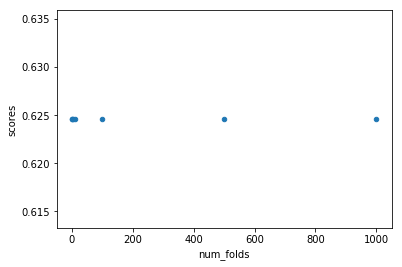

In [114]:
lists = [('num_folds', num_folds),
         ('scores', scores)]
df = pd.DataFrame.from_items(lists)
df.plot(kind='scatter', x='num_folds', y='scores')
plt.show()

3.
Another possible explanation is that the accuracy depends on the test size. As the graph below shows, we can reach a higher accuracy by lowering the size of the test set.

In [57]:
# 3. Change train/test size
scores = []
test_sizes =[]
i = 0.05
while i <= 1.0:
    def xgb_cross_validate_nfold (
        X: np.array,
        y: np.array,
        nfold: int=7
    ) -> Tuple[XGBClassifier, pd.DataFrame]:
        # eval_metrics:
        # http://xgboost.readthedocs.io/en/latest//parameter.html
        metrics = ['error@0.1', 'auc']
    #     metrics = [ 'auc' ]
        # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
        # the intent here to to minimize FAR at the expense of FRR
        alg = fresh_clf()
        xgtrain = xgb.DMatrix(X,y)
        param = alg.get_xgb_params()
        cvresults = xgb.cv(param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=nfold,
                          metrics=metrics,
                          early_stopping_rounds=100
                          )
        alg.set_params(n_estimators=cvresults.shape[0])
        alg.fit(X,y,eval_metric=metrics)
        return alg, cvresults

    relax = dataset[(dataset.label == 'relax')]
    math = dataset[(dataset.label.str.match('math\d'))]
    len(relax), len(math)

    relax_features = to_features(relax)
    math_features = to_features(math)
    features = np.concatenate([relax_features, math_features])

    assert np.all( [ len(feat) == 256 for feat in features ] )

    labels = np.array([ 0 for feature in relax_features  ] \
                    + [ 1 for feature in math_features ])


    assert len(labels) == len(features)
    assert labels[0] == 0
    assert labels[-1] == 1

    labels[:5], labels[-5:]

    assert features.shape[0] == labels.shape[0]

    features.shape, labels.shape

    X = features
    y = labels

    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
        X, y, 
        test_size=i, 
        random_state=42)

    clf, cvres = xgb_cross_validate(X_train, y_train)
    x = clf.score(X_validate, y_validate)
    scores.append(x)
    test_sizes.append(i)
    i += 0.05


In [ ]:
lists = [('test_sizes', test_sizes),
         ('scores', scores)]
df = pd.DataFrame.from_items(lists)
df.plot(kind='scatter', x='test_sizes', y='scores')
plt.show()

4. 
A further explanation, why the classifier did not do so well at all: since we only used one electrode to record, the data we gathered is very limited. Multiple electrodes could better help distinguish between baseline electrical activity and different stimuli.



5.
A further explanation why our classifier did as "well" as it did, is because we used somewhat distinguishable stimulus and control tasks. That is, the two sets (maths and relax), are different enough that they can be classified tom some extent through EEG data. Maths should show stronger activation in the Fp1 location, where we recorded using the Neurosky EEG equipment. Relax, in contrast, should only use baseline activation. 
We could further test this theory by looking at one of the other math tasks and classifying it against the other tasks. In that case, depending on the type of math task, we would expect it to be more difficult or easier to classify such a task compared to classifying the relax task against the maths tasks.
Below, we reach a very high accuracy classifying the first maths task agains all the other and the relax task. One explanation for this is that the data was set up with an oddball paradigm: the change from the relax task to the first maths task leads to a deviant stimulus from the ones before, and then change from the first maths task (which is of the type "multiplication") to the next maths tasks (which are also of type "multiplication") is not deviant. This, we would expect a different in the first maths task compared to the other maths tasks.
We could do the same for the one maths task that is deviant: where we change from multiplication to summation. The class of the task changes, and again, we would expect this to be more easily classifiable.



In [144]:
# differentiate not just b/w maths and relax -> but b/w a maths task and the rest
# Maths tasks: 12 in total -> 11 times multiplications (differing in complexity) + 1 summation in between them
# oddball paradigm: P300 signals -> change in class of task (i.e. change between multiplication and summation)

# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax')]
# All the readings taken during "math" tasks
math1 = dataset[(dataset.label == 'math1')]
math2 = dataset[(dataset.label == 'math2')]
math3 = dataset[(dataset.label == 'math3')]
math4 = dataset[(dataset.label == 'math4')]
math5 = dataset[(dataset.label == 'math5')]
math6 = dataset[(dataset.label == 'math6')]
math7 = dataset[(dataset.label == 'math7')]
math8 = dataset[(dataset.label == 'math8')]
math9 = dataset[(dataset.label == 'math9')]
math10 = dataset[(dataset.label == 'math10')]
math11 = dataset[(dataset.label == 'math11')]
math12 = dataset[(dataset.label == 'math12')]

relax_features = to_features(relax)
math1_features = to_features(math1)
math2_features = to_features(math2)
math3_features = to_features(math3)
math4_features = to_features(math4)
math5_features = to_features(math5)
math6_features = to_features(math6)
math7_features = to_features(math7)
math8_features = to_features(math8)
math9_features = to_features(math9)
math10_features = to_features(math10)
math11_features = to_features(math11)
math12_features = to_features(math12)

relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
assert np.all( [ len(feat) == 256 for feat in features ] )
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

features = np.concatenate([relax_features, math1_features, math2_features, math3_features, math4_features, math5_features, math6_features, math7_features, math8_features, math9_features, math10_features, math11_features, math12_features])
assert np.all( [ len(feat) == 256 for feat in features ] )

# loop through binary classification with all the tasks or do it in sklearn
#for i in range(0, 13, 1):
#    a = np.concatenate((features[:i-1] + features[i+1:]))

#labels = np.array([ 0 for feature in  math1_features ] \
#                + [ 1 for feature in  features[-math1_features] ])


labels = np.array([ 0 for feature in relax_features ] \
                + [ 1 for feature in math1_features ] \
                + [ 0 for feature in math2_features ] \
                + [ 0 for feature in math3_features ] \
                + [ 0 for feature in math4_features ] \
                + [ 0 for feature in math5_features ] \
                + [ 0 for feature in math6_features ] \
                + [ 0 for feature in math7_features ] \
                + [ 0 for feature in math8_features ] \
                + [ 0 for feature in math9_features ] \
                + [ 0 for feature in math10_features ] \
                + [ 0 for feature in math11_features ] \
                + [ 0 for feature in math12_features ])


# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
# assert labels[-1] == 1

assert features.shape[0] == labels.shape[0]
print(features.shape), print(labels.shape)

X = features
y = labels

X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train,)

clf.score(X_validate, y_validate)

(1870, 256)
(1870,)


0.96278317152103565

1


# Some further inquiry

We could bandpass the data to the different types of EEG waves and discover whether just these data can better predict the tasks. As seen below, we would not expect the delta waves to lead to higher accuracy. The reason is because delta waves are associated with deep sleep, but for either the maths tasks, we would be more interested in beta waves, and for the relaxed task, we would be more interested in the alpha waves.
However, bandpassing to alpha, beta or theta waves (by changing the values in the to_power_spectrum_bandpassed function accordingly - so for beta 13-30Hz, for alpha 8-12 Hz, and for theta 4-8Hz - ) also gives a lower accuracy. Thus, by filtering the data in such a way, we loose valuable information that helps us classify.

In [175]:
# bandpass to the different alpha, beta, delta, theta, gamma etc. waves -> investigate just these for the different tasks

                                      
def to_features_bandpassed (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum_bandpassed)
    return np.array([row.magnitude.values for row in power_specs])

#def bandpass_delta_to_features (
#    df: pd.DataFrame
#) -> np.array:
#    power_specs = df.raw_values.apply(to_power_spectrum)
#    power_specs_bandpassed = []
#    for i in range(0, len(power_specs), 1):
#        power_specs_bandpassed.append(power_specs.raw_values.apply(bandpass(power_specs[i], 0, 4)) #delta waves
#    return np.array([row.magnitude.values for row in power_specs_bandpassed])

def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

def to_power_spectrum_bandpassed (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    ps = bandpass(power_spectrum, 0, 4)                                
    return ps


relax = dataset[(dataset.label == 'relax')]
math = dataset[(dataset.label.str.match('math\d'))]

relax_features = to_features_bandpassed(relax)
math_features = to_features_bandpassed(math)
features = np.concatenate([relax_features, math_features])
    
#assert np.all( [ len(feat) == 256 for feat in features ] )

labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

X = features
y = labels

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

clf.score(X_validate, y_validate)

0.56148867313915862

[[  1.29823236e+08   3.08078413e+08   3.17487486e+08 ...,   2.32733526e+04
    2.93530187e+04   1.63381130e+04]
 [  4.69910250e+07   6.01655050e+08   4.74179497e+08 ...,   2.18058043e+03
    9.12413696e+02   3.91987035e+03]
 [  4.47111025e+08   8.34013140e+05   5.83195069e+07 ...,   4.99656069e+02
    8.58491020e+02   9.08773005e+02]
 ..., 
 [  4.43944900e+08   2.60799992e+06   2.30994546e+07 ...,   2.08790616e+02
    3.68511467e+02   1.19467682e+03]
 [  7.33597225e+08   7.14929866e+07   2.83082514e+07 ...,   3.57230842e+03
    2.53293426e+03   1.08431399e+03]
 [  4.19307529e+08   4.41338113e+07   1.03361433e+08 ...,   2.77296431e+03
    2.32220284e+03   1.06576553e+03]]


934

We could double the data by getting it per half a second (instead of 1 second). However, this does not change anything, although we should expect higher accuracy.



In [164]:
# We could double the data by getting it per half a second (instead of 1 second).

def to_features2 (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum_2)
    return np.array([row.magnitude.values for row in power_specs])

def to_power_spectrum_2 (
    raw_readings: np.array,
    sampling_rate: int = 256,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum


relax = dataset[(dataset.label == 'relax')]
math = dataset[(dataset.label.str.match('math\d'))]

relax_features = to_features2(relax)
math_features = to_features2(math)
features = np.concatenate([relax_features, math_features])

print(len(relax_features))
print(len(features))

assert np.all( [ len(feat) == 256 for feat in features ] )

labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

assert features.shape[0] == labels.shape[0]

X = features
y = labels

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

clf.score(X_validate, y_validate)

934
1870


0.62459546925566345